# DCRA-McCourt Partnership Insight Report
### Ziqi Niu

<br/>

## Executive Summary

The analysis utilized a clustering method that help identify which indicators are more likely to be present at certain groups of follow-up proactive inspections. According to the inspection results (approved or denied), the method divided the observations into two clusterings. Results show that although the average number of initial inspection within two groups are similar, denied inspections taks more time and money to process than approved inspections. In addition, no access to properties, not abated status and in-process repair work drag down the process of denied inspections.

## Current Approach (if applicable)

Inspection Violation Rate and NOV Compliance Rate are two main metircs to judge the effectiveness of the proactive inspection program. By comparing two kinds of rate over year, we found that the proportion of cases with violations found in total number of initial inspections increased from 2015 to 2017 (peaked at 0.71) but decreased to 0.56 when the automated selection process was implemented after Q4 2017. Meawhile increased NOV Compliance Rates suggest the continuous improvement of the abatement of violations found during the follow-up inspection process. However, to see which indicators contribute to smooth of follow-up inspections, a deeper look at the various key factors needs to be taken.

## Proposed Approach

The analysis will organize follow-up inspections into clusters based on similar attributes, such as processing time, property area, total fines, using clustering techniques. This will allow us to see if follow-up inspections perform similarly in terms of certain attributes within each group. 

## Data Sources

To focus on follow-up inspections, we selected 'proactive_inspections' and 'violation_data_count_fines'datasets.

'Proactive_inspections' datasets describes the status of all the proactive inspections, including initial and follow-up inspections after 2015. Therefore, the data will be filtered so that the inspection type only includes 'Re-Inspection'.We will keep the variable of interest from original 43 variables. Key variables will be used to measure the time for an inspection between the initial record and being considered as completed ('CAP_CreateDate' and 'Completed_Date'), inspection status('G6_STATUS'), inspection results ('INSP_RESULT_TYPE') and construction area ('square' and 'lot').

'violation_data_count_fines' datasets counts the number of violations and corresponding total fines generated after 2015. We will keep 'initial_violations' and 'total_fine' for furthuer analysis.

The two datasets mentioned above will be merged on the common attribute 'CAP_ID' (or 'cap_id'). Since attributes in the generated dataset are of different units, we will normalize the variables to avoid putting more weight on variables with smaller variance. The generated dataset has 16 variables and 4204 observations in total.

## Techniques Applied

To identify relevant groups of inspections, the data produced above is run through a K-Means clustering algorithm which finds the number of k clusters. According to the inspection result type (approved and denied), we aim to classfy the inspections into two groups (set k=2). During the process, each cluster is grouped together based on the similaritie in their attributes.

First, the algorithm creates two random centroids (the centers of two clusters) and assign each observation to the cluster of the closest centroid. Then for each cluster, the mean of the values of all the points belonging to it will be recomputed and assigned as the new value of the centroid. This process is repeated over and over until there is no change in the centroid values, meaning that all the observations have been accurately grouped.

## Findings

The dataset can be divided into 2 clusters: approved inspections and denied inspections. 

a.Both clusters have 3 initial inspections on average, however, the denied groups normally take 4 more weeks to process than approved group. 

b.It can also be found that on average denied group takes more fines (about 1500) and construction areas in terms of lot.

To smooth the inspection work, inspectors can allow more time for properties that may require large maintainence or repair work. For instance, over30-day follow-up inspections can be conducted.

## Discussion

One limitation of main concern is that the k-means clustering may not be directly applicable to categorical data. To run the data through the model, we have to transform 'INSP_RESULT_TYPE' and 'G6_STATUS' into dummies. Hence, the distance function used to assign data points to clusters may not work well for discrete data. Clustering methods more applicable for categorical variables can be considered in our further analysis.

<br/>

## Implementation
Note: You may reorganize this section or include/exclude other elements as you see fit.

In [33]:
#  Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#from sklearn.cluster import AgglomerativeClustering
#from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score

In [34]:
#  Load dataset(s)
#comp = pd.read_csv('data/complaint_inspections.csv')
pros = pd.read_csv('data/proactive_inspections.csv')
vio = pd.read_csv('data/violation_data_count_fines_severity.csv')

In [35]:
pros.head()

,As_Of_Date,CAP_CreateDate,CAP_ID,CAP_STATUS,CAP_STATUS_DATE,CAP_ALIAS,CAP_CREATED_BY_confidential,G6_Unique_ID,R3_BUREAU_CODE,Schedule_Date,...,Anc,crm_id,inspector_group,Inspector_Full_Name_confidential,status_des,inspection_type,complaint_confidential,square,lot,address_id
0,2019-08-11 19:45:05.167,2015-03-02 12:34:10.000,PRI1501648,Abated,05/03/2016,Enforce/Compliance/Housing/Proactive Inspection,0xF22FCBE6FAD693398A904285617038A3,1332136,INSPECT,2015-04-17 00:00:00.000,...,ANC 5C,NaN,Proactive,0x900777C2355169AEA72E22F5CAE9B625,Completed,Re-Inspection,"8/3 Units 102, 203\r\nActive\r\nApartment",3674,16,79354
1,2019-08-11 19:45:05.167,2015-03-02 12:34:10.000,PRI1501648,Abated,05/03/2016,Enforce/Compliance/Housing/Proactive Inspection,0xF22FCBE6FAD693398A904285617038A3,1332137,INSPECT,2015-04-17 00:00:00.000,...,ANC 5C,NaN,Proactive,0x900777C2355169AEA72E22F5CAE9B625,Completed,Re-Inspection,"8/3 Units 102, 203\r\nActive\r\nApartment",3674,16,79354
2,2019-08-11 19:45:05.167,2015-02-04 11:32:43.000,PRO1500531,Inspection Scheduled,03/27/2015,Enforce/Compliance/Housing/Proactive,0x875CD42E706029AC0095ADB5B61ABF70,1328846,INSPECT,2015-04-02 00:00:00.000,...,ANC 5B,NaN,Proactive,0x900777C2355169AEA72E22F5CAE9B625,Completed,Initial,"12/4 Units 103, 105, 107, 109\r\nDoris McVea -...",4469,94,149194
3,2019-08-11 19:45:05.167,2015-03-04 12:25:52.000,PRI1501676,NOV Served - Mail,03/16/2015,Enforce/Compliance/Housing/Proactive Inspection,0xF22FCBE6FAD693398A904285617038A3,1551616,INSPECT,2016-12-21 00:00:00.000,...,ANC 5B,NaN,Proactive,0x900777C2355169AEA72E22F5CAE9B625,Completed,Re-Inspection,"4/2 Units 3, 4\r\nActive\r\nApartment",4495,68,81204
4,2019-08-11 19:45:05.167,2015-03-04 12:29:35.000,PRI1501677,NOV Served - Mail,03/16/2015,Enforce/Compliance/Housing/Proactive Inspection,0xF22FCBE6FAD693398A904285617038A3,1551618,INSPECT,2016-12-21 00:00:00.000,...,ANC 5B,NaN,Proactive,0x900777C2355169AEA72E22F5CAE9B625,Completed,Re-Inspection,"4/2 Units 3, 4\r\nActive\r\nApartment",4495,68,81204


In [36]:
vio.head()

,cap_id,initial_violations,total_fine,1_day_violations,30_day_violations,other_violations
0,-19UNIT-INS-001854,2,2594,1,1,0
1,18ENF-HOUS-00046,7,4172,2,5,0
2,18ENF-HOUS-00050,8,5189,3,5,0
3,18ENF-HOUS-00051,12,10783,6,6,0
4,18ENF-HOUS-00053,2,1018,1,1,0


In [37]:
# Data wrangling tasks
# Select follow-up inspections
repro = pros[pros['inspection_type']=='Re-Inspection']

In [38]:
# select variables of interest
repro = repro[['CAP_CreateDate', 'CAP_ID','Completed_Date','G6_STATUS','INSP_RESULT_TYPE','square','lot']]
repro.head()

,CAP_CreateDate,CAP_ID,Completed_Date,G6_STATUS,INSP_RESULT_TYPE,square,lot
0,2015-03-02 12:34:10.000,PRI1501648,2016-12-16 09:30:00.000,Abated,APPROVED,3674,16
1,2015-03-02 12:34:10.000,PRI1501648,2016-12-16 09:29:00.000,Abated,APPROVED,3674,16
3,2015-03-04 12:25:52.000,PRI1501676,2016-12-21 10:30:00.000,No Show,APPROVED,4495,68
4,2015-03-04 12:29:35.000,PRI1501677,2016-12-21 10:30:00.000,No Show,APPROVED,4495,68
5,2015-03-04 12:25:52.000,PRI1501676,2016-12-21 10:30:00.000,No Show,APPROVED,4495,68


In [39]:
# calculate process time between initial filing and complete status
repro['processtime'] = (pd.to_datetime(repro['Completed_Date']) - pd.to_datetime(repro['CAP_CreateDate'])).map(lambda x: x.days)

In [40]:
repro = repro.drop(['CAP_CreateDate', 'Completed_Date'], axis=1)

In [41]:
repro.head()

,CAP_ID,G6_STATUS,INSP_RESULT_TYPE,square,lot,processtime
0,PRI1501648,Abated,APPROVED,3674,16,654
1,PRI1501648,Abated,APPROVED,3674,16,654
3,PRI1501676,No Show,APPROVED,4495,68,657
4,PRI1501677,No Show,APPROVED,4495,68,657
5,PRI1501676,No Show,APPROVED,4495,68,657


In [42]:
# Merge pros and violations datasets
dat = pd.merge(vio, repro, left_on='cap_id',right_on='CAP_ID')
dat.head()

,cap_id,initial_violations,total_fine,1_day_violations,30_day_violations,other_violations,CAP_ID,G6_STATUS,INSP_RESULT_TYPE,square,lot,processtime
0,18UNIT-INS-001097,1,2034,1,0,0,18UNIT-INS-001097,Abated,APPROVED,2967,78,222
1,18UNIT-INS-001097,1,2034,1,0,0,18UNIT-INS-001097,Abated,APPROVED,2967,78,222
2,18UNIT-INS-001098,2,1526,1,1,0,18UNIT-INS-001098,Abated,APPROVED,2967,78,222
3,18UNIT-INS-001098,2,1526,1,1,0,18UNIT-INS-001098,Abated,APPROVED,2967,78,222
4,18UNIT-INS-001100,1,1017,1,0,0,18UNIT-INS-001100,Abated,APPROVED,2957,807,222


In [43]:
# drop irrelevant variables
dat=dat.drop(['cap_id', '1_day_violations','30_day_violations','other_violations','CAP_ID'],1)

In [51]:
# transform categorical varibles into dummies
dum_g6 = pd.get_dummies(dat['G6_STATUS'])
result = pd.get_dummies(dat['INSP_RESULT_TYPE'])
df = pd.concat([dat,dum_g6,result], axis=1)

In [52]:
df.head()

,initial_violations,total_fine,G6_STATUS,INSP_RESULT_TYPE,square,lot,processtime,Abated,Approved,Cause,Final No Access,No Access,No Cause,No Show,Not Abated,Work in Progress,APPROVED,DENIED
0,1,2034,Abated,APPROVED,2967,78,222,1,0,0,0,0,0,0,0,0,1,0
1,1,2034,Abated,APPROVED,2967,78,222,1,0,0,0,0,0,0,0,0,1,0
2,2,1526,Abated,APPROVED,2967,78,222,1,0,0,0,0,0,0,0,0,1,0
3,2,1526,Abated,APPROVED,2967,78,222,1,0,0,0,0,0,0,0,0,1,0
4,1,1017,Abated,APPROVED,2957,807,222,1,0,0,0,0,0,0,0,0,1,0


In [53]:
df = df.drop(['G6_STATUS', 'INSP_RESULT_TYPE'],1)

In [54]:
df.head()

,initial_violations,total_fine,square,lot,processtime,Abated,Approved,Cause,Final No Access,No Access,No Cause,No Show,Not Abated,Work in Progress,APPROVED,DENIED
0,1,2034,2967,78,222,1,0,0,0,0,0,0,0,0,1,0
1,1,2034,2967,78,222,1,0,0,0,0,0,0,0,0,1,0
2,2,1526,2967,78,222,1,0,0,0,0,0,0,0,0,1,0
3,2,1526,2967,78,222,1,0,0,0,0,0,0,0,0,1,0
4,1,1017,2957,807,222,1,0,0,0,0,0,0,0,0,1,0


In [55]:
# Assess missing values
df.isnull().sum()

initial_violations    0
total_fine            0
square                0
lot                   0
processtime           0
Abated                0
Approved              0
Cause                 0
Final No Access       0
No Access             0
No Cause              0
No Show               0
Not Abated            0
Work in Progress      0
APPROVED              0
DENIED                0
dtype: int64

In [62]:
df = df[df['square']!='PAR']

In [70]:
df.shape

(4204, 16)

In [86]:
#  Modeling tasks
# standardize variables
df= df.astype(np.float64)
x = pd.DataFrame(StandardScaler().fit_transform(df), columns = df.columns)
x.head()

,initial_violations,total_fine,square,lot,processtime,Abated,Approved,Cause,Final No Access,No Access,No Cause,No Show,Not Abated,Work in Progress,APPROVED,DENIED
0,-0.930089,-0.487155,-0.175661,-0.704933,2.48742,0.528552,-0.021817,-0.030861,-0.081884,-0.170678,-0.015425,-0.267125,-0.329621,-0.132004,0.598598,-0.598598
1,-0.930089,-0.487155,-0.175661,-0.704933,2.48742,0.528552,-0.021817,-0.030861,-0.081884,-0.170678,-0.015425,-0.267125,-0.329621,-0.132004,0.598598,-0.598598
2,-0.592954,-0.694847,-0.175661,-0.704933,2.48742,0.528552,-0.021817,-0.030861,-0.081884,-0.170678,-0.015425,-0.267125,-0.329621,-0.132004,0.598598,-0.598598
3,-0.592954,-0.694847,-0.175661,-0.704933,2.48742,0.528552,-0.021817,-0.030861,-0.081884,-0.170678,-0.015425,-0.267125,-0.329621,-0.132004,0.598598,-0.598598
4,-0.930089,-0.902948,-0.181337,1.287282,2.48742,0.528552,-0.021817,-0.030861,-0.081884,-0.170678,-0.015425,-0.267125,-0.329621,-0.132004,0.598598,-0.598598


In [87]:
# fit clustering model (set k=2)
kmeans = KMeans(n_clusters=2, random_state=0).fit(x)
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [88]:
# Add lable as a new column
group = pd.DataFrame(kmeans.labels_)
df2 = pd.concat([df,group], axis=1)

In [89]:
df2.head()

,initial_violations,total_fine,square,lot,processtime,Abated,Approved,Cause,Final No Access,No Access,No Cause,No Show,Not Abated,Work in Progress,APPROVED,DENIED,0
0,1.0,2034.0,2967.0,78.0,222.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,2034.0,2967.0,78.0,222.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.0,1526.0,2967.0,78.0,222.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.0,1526.0,2967.0,78.0,222.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1017.0,2957.0,807.0,222.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [90]:
# calculate mean values for each attribute within each cluster
df2.groupby(0).mean()

,initial_violations,total_fine,square,lot,processtime,Abated,Approved,Cause,Final No Access,No Access,No Cause,No Show,Not Abated,Work in Progress,APPROVED,DENIED
0,,,,,,,,,,,,,,,,
0.0,3.826016,2853.058322,3302.649738,329.345675,78.90498,0.808322,0.000655,0.001311,0.002621,0.000000,0.000328,0.091743,0.095020,0.000000,0.998689,0.001311
1.0,3.611765,4307.294118,3205.191855,356.416290,103.99095,0.701357,0.000000,0.000000,0.018100,0.107692,0.000000,0.000000,0.107692,0.065158,0.000000,1.000000


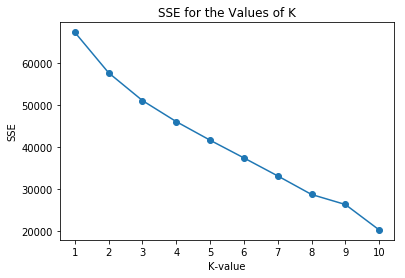

In [69]:
# Evaluation
#Calculate Sum of Squared Error for K values from 1 to 10
inertia = [KMeans(n_clusters=i).fit(x).inertia_ for i in range(1,11)]
plt.plot(inertia, marker='o')
plt.xlabel('K-value')
plt.ylabel('SSE')
plt.xticks(np.arange(10),(range(1,11)))
plt.title('SSE for the Values of K')
plt.show()

Common measure for evaluating clustering is to compute the Sum of Squared Error(SSE).  As the number of clusters increases, SSE decreases.Unfortunately,there is no obvious elbow to pick a value of K.

In [91]:
# silhouette score for K between 2 and 10
scores = [silhouette_score(x, KMeans(n_clusters=i, random_state=0).fit(x).labels_) for i in range(2, 10)]
scores

[0.2980324343406191,
 0.32761491231512846,
 0.34255351115456756,
 0.3789884758629206,
 0.37979269199207505,
 0.35738215611482343,
 0.38322249057645025,
 0.31148246150331826]

The scores are positive, which indicates the observations are relatively better matched to their own cluster and badly matched to other clusters. Normally, a higher Silhouette Coefficient score relates to a model with better defined clusters.In this case, the highest score appears when K=8, which suggests the predefined K(2) is not optimal for clustering.

In [92]:
# fit clustering model (set k=8)
kmeans8 = KMeans(n_clusters=8, random_state=0).fit(x)
kmeans8.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [93]:
# Add lable as a new column
group = pd.DataFrame(kmeans8.labels_)
df3 = pd.concat([df,group], axis=1)
df3.head()

,initial_violations,total_fine,square,lot,processtime,Abated,Approved,Cause,Final No Access,No Access,No Cause,No Show,Not Abated,Work in Progress,APPROVED,DENIED,0
0,1.0,2034.0,2967.0,78.0,222.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,2034.0,2967.0,78.0,222.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,2.0,1526.0,2967.0,78.0,222.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,2.0,1526.0,2967.0,78.0,222.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.0,1017.0,2957.0,807.0,222.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [94]:
# calculate mean values for each attribute within each cluster
df3.groupby(0).mean()

,initial_violations,total_fine,square,lot,processtime,Abated,Approved,Cause,Final No Access,No Access,No Cause,No Show,Not Abated,Work in Progress,APPROVED,DENIED
0,,,,,,,,,,,,,,,,
0.0,5.801956,4239.337408,4016.907090,351.938875,85.212714,0.344743,0.000000,0.000000,0.0,0.000000,0.000000,0.127139,0.525672,0.002445,0.701711,0.298289
1.0,3.489879,2801.817814,3219.555466,323.017004,80.736437,0.869636,0.000405,0.001619,0.0,0.000000,0.000405,0.071660,0.056275,0.000000,0.999190,0.000810
2.0,4.660777,2656.537102,3350.381625,344.498233,68.303887,0.657244,0.003534,0.000000,0.0,0.000000,0.000000,0.180212,0.159011,0.000000,1.000000,0.000000
3.0,3.142119,3878.649871,2841.591731,353.400517,101.383721,0.953488,0.000000,0.000000,0.0,0.006460,0.000000,0.000000,0.012920,0.027132,0.000000,1.000000
4.0,3.899160,4609.302521,4194.042017,420.546218,114.319328,0.050420,0.000000,0.000000,0.0,0.949580,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
5.0,4.472222,5155.458333,3572.708333,359.527778,102.000000,0.291667,0.000000,0.000000,0.0,0.013889,0.000000,0.000000,0.000000,0.694444,0.000000,1.000000
6.0,3.000000,2300.000000,4654.000000,35.500000,68.500000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
7.0,4.714286,4805.000000,4036.535714,363.607143,91.821429,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.714286


When the data is divided into 8 clusters, it is hard to differentiate features betwwen each cluster. In this case the different type of inspections (abated, approved, cause...) contribute a lot to the clustering.